# Algoritmo de Bertnstein-Vazirani

In [1]:
import numpy as np
from qiskit import IBMQ, QuantumCircuit, Aer, execute
from qiskit.quantum_info import Operator
from qiskit.providers.ibmq import least_busy
from qiskit.visualization import plot_histogram
from qiskit.tools.jupyter import *
provider = IBMQ.load_account()

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.9/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


Empezamos creando nuestro circuito que consiste de cuatro cubits y un cubit ancilla. Despues definimos nuestra cadena secreta de bits *shh*.

In [2]:
# Numero secreto
shh = '1010'
# Necesitamos un numero de cubits igual al numero de digitos en nuestra cadena secreta de bits
input_qubits = len(shh)
ancilla_qubit = 1
total_qubits = input_qubits + ancilla_qubit

#Inicializamos nuestro circuito cuantico
qc = QuantumCircuit(total_qubits, input_qubits)

Despues añadimos las compuertas de Hadamards a los cubits de entrada, asegurandonos de que estan en un estado de superposicion

In [3]:
for idx in range(input_qubits):
    qc.h(idx)

qc.draw()

┌───┐
q_0: ┤ H ├
     ├───┤
q_1: ┤ H ├
     ├───┤
q_2: ┤ H ├
     ├───┤
q_3: ┤ H ├
     └───┘
q_4: ─────
          
c: 4/═════

Ahora preparamos el cubit ancilla, primero rotandolo al estado |1> y despues aplicando la compuerta de Hadamard.

In [4]:
qc.x(total_qubits-1)
qc.h(total_qubits-1)
qc.barrier()

qc.draw()

┌───┐      ░ 
q_0: ┤ H ├──────░─
     ├───┤      ░ 
q_1: ┤ H ├──────░─
     ├───┤      ░ 
q_2: ┤ H ├──────░─
     ├───┤      ░ 
q_3: ┤ H ├──────░─
     ├───┤┌───┐ ░ 
q_4: ┤ X ├┤ H ├─░─
     └───┘└───┘ ░ 
c: 4/═════════════

Ahora, necesitamos hacer un ajuste en el ordern de los bits. Los cubits estan alineados de izquiera a derecha, necesitamos invertir el orden de nuestro numero secreto, antes de aplicar el oraculo.

In [5]:
print('Numero secreto antes de invertir el orden: ', shh)
shh = shh[::-1]
print('Numero despues de invertir el orden de los bits: ', shh)

Numero secreto antes de invertir el orden:  1010
Numero despues de invertir el orden de los bits:  0101


Para aplicar el oraculo, necesitamos activar el cambio de fase cada vez que encontramos un '1' en nuestra cadena de bits. Para hacerlo, aplicamos una compuerta CNOT en cada uno de nuestros cubits de entrada, donde el control es cada uno de los cubits de entrada y el target es el cubit ancilla.

In [6]:
for idx in range(input_qubits):
    if shh[idx] == '1':
        qc.cx(idx, input_qubits)

qc.barrier()
qc.draw()

┌───┐      ░            ░ 
q_0: ┤ H ├──────░────────────░─
     ├───┤      ░            ░ 
q_1: ┤ H ├──────░───■────────░─
     ├───┤      ░   │        ░ 
q_2: ┤ H ├──────░───┼────────░─
     ├───┤      ░   │        ░ 
q_3: ┤ H ├──────░───┼────■───░─
     ├───┤┌───┐ ░ ┌─┴─┐┌─┴─┐ ░ 
q_4: ┤ X ├┤ H ├─░─┤ X ├┤ X ├─░─
     └───┘└───┘ ░ └───┘└───┘ ░ 
c: 4/══════════════════════════

Hasta la primera barrera, nuestros cubits de entrada estan en el estado |+>, en superposicion, si el bit correspondiente es igual a '1', se aplica el cambio de fase de |+> a |->. El ultimo paso es aplicar un segundo set de compuertas de Hadamard, que rotara los cubits de entrada al estado |0> o |1>, dependiendo de si se encontraban en |+> o |1>, respectivamente.

In [7]:
for idx in range(input_qubits):
    qc.h(idx)

qc.barrier()
qc.draw()

┌───┐      ░            ░ ┌───┐ ░ 
q_0: ┤ H ├──────░────────────░─┤ H ├─░─
     ├───┤      ░            ░ ├───┤ ░ 
q_1: ┤ H ├──────░───■────────░─┤ H ├─░─
     ├───┤      ░   │        ░ ├───┤ ░ 
q_2: ┤ H ├──────░───┼────────░─┤ H ├─░─
     ├───┤      ░   │        ░ ├───┤ ░ 
q_3: ┤ H ├──────░───┼────■───░─┤ H ├─░─
     ├───┤┌───┐ ░ ┌─┴─┐┌─┴─┐ ░ └───┘ ░ 
q_4: ┤ X ├┤ H ├─░─┤ X ├┤ X ├─░───────░─
     └───┘└───┘ ░ └───┘└───┘ ░       ░ 
c: 4/══════════════════════════════════

Finalmente, añadimos los operadores de medicion:

In [8]:
qc.measure(range(input_qubits), range(input_qubits))
qc.draw()

┌───┐      ░            ░ ┌───┐ ░ ┌─┐         
q_0: ┤ H ├──────░────────────░─┤ H ├─░─┤M├─────────
     ├───┤      ░            ░ ├───┤ ░ └╥┘┌─┐      
q_1: ┤ H ├──────░───■────────░─┤ H ├─░──╫─┤M├──────
     ├───┤      ░   │        ░ ├───┤ ░  ║ └╥┘┌─┐   
q_2: ┤ H ├──────░───┼────────░─┤ H ├─░──╫──╫─┤M├───
     ├───┤      ░   │        ░ ├───┤ ░  ║  ║ └╥┘┌─┐
q_3: ┤ H ├──────░───┼────■───░─┤ H ├─░──╫──╫──╫─┤M├
     ├───┤┌───┐ ░ ┌─┴─┐┌─┴─┐ ░ └───┘ ░  ║  ║  ║ └╥┘
q_4: ┤ X ├┤ H ├─░─┤ X ├┤ X ├─░───────░──╫──╫──╫──╫─
     └───┘└───┘ ░ └───┘└───┘ ░       ░  ║  ║  ║  ║ 
c: 4/═══════════════════════════════════╩══╩══╩══╩═
                                        0  1  2  3

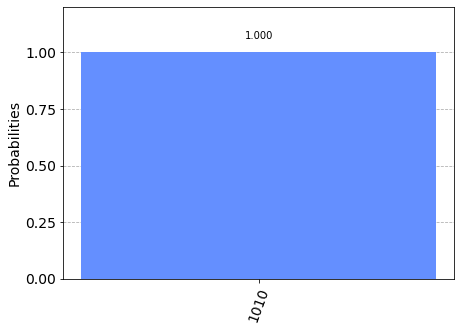

In [10]:
backend = Aer.get_backend('qasm_simulator')
result = execute(qc, backend, shots=1024).result()
counts = result.get_counts(qc)
plot_histogram(counts)

In [11]:
%qiskit_job_watcher

Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

In [15]:
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 5 and not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend)

least busy backend:  ibmq_belem


In [16]:
backend = provider.get_backend('ibmq_belem')
result = execute(qc, backend=backend, shots=1024).result()

{'0000': 43, '0001': 13, '0010': 100, '0011': 43, '0100': 13, '0101': 4, '0110': 48, '0111': 13, '1000': 66, '1001': 15, '1010': 451, '1011': 53, '1100': 23, '1101': 2, '1110': 124, '1111': 13}


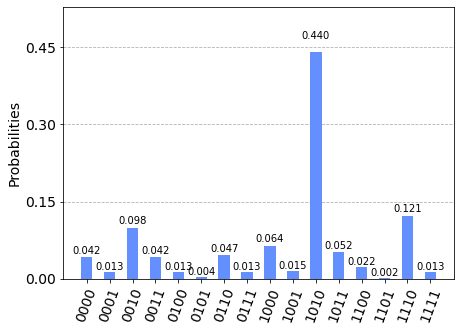

In [17]:
counts = result.get_counts(qc)
print(counts)
plot_histogram(counts)

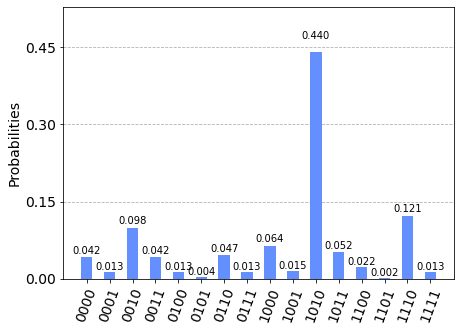

In [18]:
# Jobs I ran before
backend = provider.get_backend('ibmq_belem')
old_job = backend.retrieve_job('61241348bdd6b18b7f028c5c')
results = old_job.result()
answer = results.get_counts()
plot_histogram(answer)